In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf 
import re
from collections import defaultdict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Concatenate, Activation, Reshape,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Lambda
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

2025-12-19 16:12:19.112305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766160739.292305      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766160739.359617      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766160739.805982      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766160739.806027      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766160739.806030      55 computation_placer.cc:177] computation placer alr

In [2]:
#dataset path
images_path = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"


In [3]:
# load images from the dataset
def load_flickr_captions_csv(filename):
    df = pd.read_csv(filename)
    captions_dict = defaultdict(list)    #Creates an empty dictionary where each key starts with an empty list by default
    for _, row in df.iterrows():         # _ ignore row index , row access caption and image
        captions_dict[row["image"]].append(row["caption"])  #Appends caption to the matching image
    return captions_dict

captions_dict = load_flickr_captions_csv(captions_file)
print("Total images:", len(captions_dict))


Total images: 8091


In [4]:
# preprocessing on text
def clean_caption(caption):
    caption = caption.lower().strip()
    return caption
# prepare for decoder input
for img in captions_dict:
    captions_dict[img] = [
        "<STARTSEQ> " + clean_caption(c) + " <ENDSEQ>"
        for c in captions_dict[img]
    ]


In [5]:
example_img = list(captions_dict.keys())[0]   # first image
print(example_img) # image name
print(captions_dict[example_img]) # image captions 

1000268201_693b08cb0e.jpg
['<STARTSEQ> a child in a pink dress is climbing up a set of stairs in an entry way . <ENDSEQ>', '<STARTSEQ> a girl going into a wooden building . <ENDSEQ>', '<STARTSEQ> a little girl climbing into a wooden playhouse . <ENDSEQ>', '<STARTSEQ> a little girl climbing the stairs to her playhouse . <ENDSEQ>', '<STARTSEQ> a little girl in a pink dress going into a wooden cabin . <ENDSEQ>']


In [6]:
all_captions = []
for caps in captions_dict.values():
    all_captions.extend(caps)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(c.split()) for c in all_captions)

print("Vocab size:", vocab_size)
print("Max caption length:", max_len)


Vocab size: 8496
Max caption length: 40


In [7]:
# data augmentation 
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,   # Applies shearing (slanted stretching)
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
# zbt shakl el encoder input w decoder input w decoder output
# encoder input wakhd image 
# decoder 5adna el max length w 3mlna padding ll input w nfso output bs 3mlna shift 
def load_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)   # convert to machine readable
    img = preprocess_input(img)
    return img

X_images = []    # encoder input
X_captions_input = []   # decoder input
y_captions_output = []  # decoder output

for img_name, captions in captions_dict.items():
    img_path = os.path.join(images_path, img_name)
    image = load_image(img_path)
    
    for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        in_seq = seq[:]   #all
        out_seq = seq[1:] # shifted

        in_seq = pad_sequences([in_seq], maxlen=max_len, padding="post")[0]   # [0] to acess [[]]
        out_seq = pad_sequences([out_seq], maxlen=max_len, padding="post")[0]

        X_images.append(image)
        X_captions_input.append(in_seq)
        y_captions_output.append(out_seq)

X_images = np.array(X_images, dtype=np.float16)
X_captions_input = np.array(X_captions_input, dtype=np.int16)
y_captions_output = np.array(y_captions_output, dtype=np.int16)

print("X_images:", X_images.shape)    #encoder input
print("X_captions_input:", X_captions_input.shape)    #decoder output
print("y_captions_output:", y_captions_output.shape)  #decoder input


X_images: (40455, 224, 224, 3)
X_captions_input: (40455, 40)
y_captions_output: (40455, 40)


In [10]:
X_train_imgs, X_val_imgs, X_train_inp, X_val_inp, y_train, y_val = train_test_split(
    X_images, X_captions_input, y_captions_output, test_size=0.2, random_state=42
)

print("Training images:", X_train_imgs.shape)
print("Validation images:", X_val_imgs.shape)
print("Training decoder input:", X_train_inp.shape)
print("Validation decoder input:", X_val_inp.shape)
print("Training decoder output:", y_train.shape)
print("Validation decoder output:", y_val.shape)


Training images: (32364, 224, 224, 3)
Validation images: (8091, 224, 224, 3)
Training decoder input: (32364, 40)
Validation decoder input: (8091, 40)
Training decoder output: (32364, 40)
Validation decoder output: (8091, 40)


In [11]:
del X_images, X_captions_input,y_captions_output

In [12]:
# encoder input
encoder_input = Input(shape=(224, 224, 3), name="encoder_input")

# load resnet50 base model spatial features, no pooling
resnet_base = ResNet50(include_top=False, 
                       weights="imagenet",
                       input_tensor=encoder_input)

for layer in resnet_base.layers[:-20]:
    layer.trainable = False
for layer in resnet_base.layers[-20:]:
    layer.trainable = True
# output shape from renet50 
x = resnet_base.output   # (batch,7,7,2048)  7*7 spatial dimention ,2048 chanels or features

# Prepare features for attention to help decoder to focus on specific regions
# Flatten spatial grid → 49 feature vectors
x = Reshape((49, 2048))(x)   # (batch,49,2048)

# Reduce dimensionality for decoder hidden size
encoder_output = Dense(512, activation="relu")(x)   # (batch_size, 49, 512)
encoder_output = Dropout(0.3)(encoder_output)
#Input= raw image, Output= processed feature vectors for the decoder with attention
encoder_model = Model(inputs=encoder_input, outputs=encoder_output)


I0000 00:00:1766161023.328569      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
glove_path = "/kaggle/input/text-data/glove.6B.100d.txt"
embedding_dim = 100

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")


Loaded 400000 word vectors from GloVe.


In [14]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():   # word , number of row in embedding matrix 
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [15]:
# decoder 
decoder_input = Input(shape=(max_len,), name="decoder_input")   #(batch size, max_len)

# Embedding layer
embedding = Embedding(
    vocab_size,
    embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(decoder_input)  #Output shape: (batch_size, max_len, embedding_dim)

embedding = Dropout(0.2)(embedding)


# h0 and c0 → initial hidden state and cell state for the decoder LSTM.
# Compute mean across the 49 spatial vectors
h0 = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="init_h")(encoder_output)  
c0 = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="init_c")(encoder_output)  


# decoder lstm 
decoder_lstm = LSTM(  
    512,
    return_sequences=True, # all hidden states "need for attention"
    return_state=True,# final hidden state
    dropout=0.3,           #dropout on input 
    recurrent_dropout=0.3, # dropout on hidden states
    name="decoder_lstm"
)   

decoder_seq, state_h, state_c = decoder_lstm(    #decoder seq (batch size, max_len, 512)
    embedding, initial_state=[h0, c0]            # initial states (batch size , 512) for both 
)


In [16]:
# attention 
#dot product along feature dimension to compute similarity between each decoder timestep and each encoder spatial vector.
score = layers.Dot(axes=[2,2], name="attention_score")([decoder_seq, encoder_output])   #score= (batch size,max len,49)

# softmax attention matrix probabilities for features
attention_weights = layers.Activation('softmax', name="attention_weights")(score)

# context = weighted sum of encoder output "multiply attention weights by encoder feature"
context = layers.Dot(axes=[2,1], name="context_vector")([attention_weights, encoder_output])   # (batch_size, max_len, 512)

# concatenate context + decoder timestep output
decoder_combined = Concatenate(axis=-1, name="decoder_context_concat")([decoder_seq, context])  # (batch size , max len ,1024 "512+512")
decoder_concat = Dropout(0.3)(decoder_combined)
decoder_dense = Dense(vocab_size, activation="softmax", name="output_dense") #(batch_size, max_len, vocab_size) Maps combined features to vocabulary probabilities
output = decoder_dense(decoder_combined)

In [17]:
model = Model(inputs=[encoder_input, decoder_input], outputs=output)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ encoder_input[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 35,450,224 (135.23 MB)

 Trainable params: 19,944,240 (76.08 MB)

 Non-trainable params: 15,505,984 (59.15 MB)

In [18]:
def array_data_generator(X_imgs, X_inp, y_out, batch_size=32, augment=False):
    num_samples = len(X_imgs)
    while True:
        for i in range(0, num_samples, batch_size):
            batch_imgs = X_imgs[i:i+batch_size].copy().astype(np.float32) #ensures images are float arrays
            batch_inp  = X_inp[i:i+batch_size]
            batch_out  = y_out[i:i+batch_size]
            
            if augment:
                # apply augmentation 
                for j in range(len(batch_imgs)):
                    batch_imgs[j] = datagen.random_transform(batch_imgs[j])
            
            yield (batch_imgs, batch_inp), batch_out  # Sends the batch to the model


In [19]:
train_gen = array_data_generator(X_train_imgs, X_train_inp, y_train, batch_size=32, augment=True)
val_gen   = array_data_generator(X_val_imgs, X_val_inp, y_val, batch_size=32, augment=False)

steps_per_epoch = len(X_train_imgs) // 32
val_steps = len(X_val_imgs) // 32




In [20]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

In [21]:
model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/60


I0000 00:00:1766161049.140140     124 cuda_dnn.cc:529] Loaded cuDNN version 91002


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 2.2841
Epoch 1: val_loss improved from inf to 1.41681, saving model to best_model.weights.h5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 399s 380ms/step - loss: 2.2835 - val_loss: 1.4168 - learning_rate: 1.0000e-04
Epoch 2/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - loss: 1.3468
Epoch 2: val_loss improved from 1.41681 to 1.24113, saving model to best_model.weights.h5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 380s 376ms/step - loss: 1.3468 - val_loss: 1.2411 - learning_rate: 1.0000e-04
Epoch 3/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 1.1980
Epoch 3: val_loss improved from 1.24113 to 1.15309, saving model to best_model.weights.h5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 380s 376ms/step - loss: 1.1980 - val_loss: 1.1531 - learning_rate: 1.0000e-04
Epoch 4/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 1.1159
Epoch 4: val_loss improved from 1.15309 to 1.09714, saving model to best_model.weights.h5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 378s 374ms/st

In [22]:
model.save("english_caption_60epoch.keras")

In [54]:
# Encoder input (already built)
encoder_inputs = encoder_input  # shape=(224,224,3)
# Decoder inputs
decoder_inputs_inf = Input(shape=(1,), name="decoder_input_inf")  # one word at a time (batch_size, 1, embedding_dim)
state_h_input = Input(shape=(512,), name="state_h_input")   # batch size, 512
state_c_input = Input(shape=(512,), name="state_c_input")
encoder_out_input = Input(shape=(49, 512), name="encoder_out_input")   # batch size , 49 ,512 
embedding_inf = model.get_layer("embedding")(decoder_inputs_inf)#(batch_size, 1,100)get embedding of one word from the same embedding layer 
decoder_lstm_layer = model.get_layer("decoder_lstm")    

decoder_seq_inf, state_h_out, state_c_out = decoder_lstm_layer(  # decoder lstm take last + now word
    embedding_inf, initial_state=[state_h_input, state_c_input]   # batch_size, 1,512
)
# Attention layers from training model
attention_score_layer = model.get_layer("attention_score")
attention_weights_layer = model.get_layer("attention_weights")
context_layer = model.get_layer("context_vector")
concat_layer = model.get_layer("decoder_context_concat")
dense_layer = model.get_layer("output_dense")

score_inf = attention_score_layer([decoder_seq_inf, encoder_out_input])  #(batch size,1,512)(batch ize,49,512) ,score=(batch size, 1,49)
attention_weights_inf = attention_weights_layer(score_inf)
context_inf = context_layer([attention_weights_inf, encoder_out_input])  # batch_size, 1 1 ,512
decoder_combined_inf = concat_layer([decoder_seq_inf, context_inf])   # batch size , 1,1024

output_inf = dense_layer(decoder_combined_inf)  # predicted word probabilities  (batch size , 1,vocab size)


In [55]:
inference_model = Model(
    inputs=[decoder_inputs_inf, state_h_input, state_c_input, encoder_out_input],
    outputs=[output_inf, state_h_out, state_c_out]
)


In [92]:
def generate_caption_beam_fixed(encoder_feature, tokenizer, max_len=35, beam_width=3):
    start_token = tokenizer.word_index['startseq']
    end_token = tokenizer.word_index['endseq']

    sequences = [[ [start_token], 0.0, np.zeros((1,512)), np.zeros((1,512)) ]]   # word , prob ,state_h ,state_c intialize with zero

    for _ in range(max_len):
        all_candidates = []  # all available woeds 
        finished_sequences = []   # choosen to endseq word

        for seq, score, state_h, state_c in sequences:
            # If last word is end_token no new word generation 
            if seq[-1] == end_token:
                finished_sequences.append([seq, score])
                continue

            # Predict next word
            seq_input = np.array([seq[-1]]).reshape(1,1)
            yhat, state_h_new, state_c_new = inference_model.predict(
                [seq_input, state_h, state_c, encoder_feature], verbose=0
            )

            # Pick top-k probabilities **descending**
            top_indices = np.argsort(yhat[0,0])[::-1][:beam_width]

            for idx in top_indices:
                candidate_seq = seq + [idx]
                candidate_score = score - np.log(yhat[0,0,idx]+1e-10)
                all_candidates.append([candidate_seq, candidate_score, state_h_new, state_c_new])

        # Keep top-k sequences
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

        # If all sequences have finished, break
        if len(finished_sequences) >= beam_width:
            break

    # Add finished sequences if any
    if finished_sequences:
        sequences = sorted(finished_sequences, key=lambda tup: tup[1])
        best_seq = sequences[0][0]
    else:
        best_seq = sequences[0][0]

    # Convert indices to words safely
    reverse_word_index = {v:k for k,v in tokenizer.word_index.items()}
    caption_words = [
        reverse_word_index[int(i)]
        for i in best_seq
        if i not in [start_token, end_token] and int(i) in reverse_word_index
    ]

    return ' '.join(caption_words)


In [93]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

def extract_resnet_features(image_path, encoder_model):
    # Load image and resize to 224x224
        img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Preprocess for ResNet
    img = preprocess_input(img)

    # Extract features
    features = encoder_model.predict(img, verbose=0)  # shape (1, 49, 512)
    return features[0]  # return shape (49, 512)


In [100]:
image_path = r"/kaggle/input/flickr8k/Images/102351840_323e3de834.jpg"
img_feature = extract_resnet_features(image_path, encoder_model)
img_feature = np.expand_dims(img_feature, axis=0)  # add batch dim

caption = generate_caption_beam_fixed(img_feature, tokenizer)
print("Predicted caption:", caption)


Predicted caption: the ice ice skating rink in the background


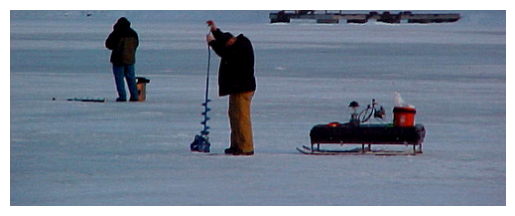

In [101]:
import matplotlib.pyplot as plt
from PIL import Image

def show_image(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
img_path = "/kaggle/input/flickr8k/Images/102351840_323e3de834.jpg"
show_image(img_path)

In [50]:
def load_and_process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def generate_caption(model, tokenizer, image_path, max_len):
    # load & preprocess image
    img = load_and_process_image(image_path)   # shape (1,224,224,3)

    start_token = tokenizer.word_index['startseq']
    end_token   = tokenizer.word_index['endseq']

    caption_seq = [start_token]

    for _ in range(max_len):
        seq = pad_sequences([caption_seq], maxlen=max_len, padding='post')

        preds = model.predict([img, seq], verbose=0)

        next_id = np.argmax(preds[0, len(caption_seq)-1])

        if next_id == 0:
            break

        caption_seq.append(next_id)

        if next_id == end_token:
            break

    caption = [tokenizer.index_word[i] for i in caption_seq
               if i not in [start_token, end_token, 0]]

    return " ".join(caption)



test_image = "/kaggle/input/sora-mn-bara/Screenshot 2025-12-19 013622.png"
print(generate_caption(model, tokenizer, test_image, max_len))



a dog runs through the grass
